# Data Cleaning and Urban separation

This notebook is first used to clean twitter data and keep only useful information. 

It then produce, using the cleaned data, a "Urban mask" on the tweets. The mask will give the information if the tweet was written in a urban area of switzerland, or in a non-urban area.

Using only non-urban tweets, a k-mean clustering algorithm is run in order to detect area of interests in non-urban zone of Switzerland. 

This script produces a tsv file containing for each non-urban area: The id, date, latitude, longitude, and the cluster it has been assigned too. Another tsv file containing clusters information is produced.

In [3]:
#Imports
import os
import json
import pandas as pd
import numpy as np
import csv
# Install GDAL for python to read TIFF urban mask :
#conda install -c conda-forge gdal=2.1.2
import gdal 


## Data import

The data twex.tsv is read line by line. Each row should contain 20 elements. Since there are unclean data, it occurs that some tweets are separated on several line. Since there are around 20Millions of tweets, we can afford do discard the unclean ones.

We therefore only keep the rows with exactly 20 elements, and keep only the id, date, latitude, longitude of the tweet.

*PS: The code has been commented to avoid running each time, the next cell loads directly the clean file*

In [41]:
"""
path = 'data/twex.tsv'
nb_fields = 20
cleanedPath = "data/cleaned.tsv"
with open(path) as infile:
    with open(cleanedPath, "w") as outputfile:
        i=0
        for line in infile:
            i = i+1
            if i%200000 == 0:
                print("line:", i)
            line_array = line.split("\t")
            if(len(line_array) == nb_fields):
                if line_array[4] != "\\N":
                    outputfile.write(line_array[0])
                    outputfile.write("\t")
                    outputfile.write(line_array[2])
                    outputfile.write("\t")
                    outputfile.write(line_array[4])
                    outputfile.write("\t")
                    outputfile.write(line_array[5])
                    outputfile.write("\n")
        outputfile.close()
    infile.close()"""

'\npath = \'data/twex.tsv\'\nnb_fields = 20\ncleanedPath = "data/cleaned.tsv"\nwith open(path) as infile:\n    with open(cleanedPath, "w") as outputfile:\n        i=0\n        for line in infile:\n            i = i+1\n            if i%200000 == 0:\n                print("line:", i)\n            line_array = line.split("\t")\n            if(len(line_array) == nb_fields):\n                if line_array[4] != "\\N":\n                    outputfile.write(line_array[0])\n                    outputfile.write("\t")\n                    outputfile.write(line_array[2])\n                    outputfile.write("\t")\n                    outputfile.write(line_array[4])\n                    outputfile.write("\t")\n                    outputfile.write(line_array[5])\n                    outputfile.write("\n")\n        outputfile.close()\n    infile.close()'

In [4]:
data = pd.DataFrame.from_csv("data/cleaned.tsv", sep="\t", header=None)

In [5]:
data.columns=["date","longitude","latitude"]
localisation = data[["latitude","longitude"]]
data.head()

,date,longitude,latitude
0,,,
9514097914,2010-02-23 05:55:51,7.43926,46.9489
9514846412,2010-02-23 06:22:40,8.53781,47.3678
9516574359,2010-02-23 07:34:25,6.13396,46.1951
9516952605,2010-02-23 07:51:47,8.81749,47.2288
9517198943,2010-02-23 08:02:57,6.63254,46.5199


## Urban Mask

### Reading mask file

We read the urban mask in TIFF format generated by the Google Earth engine code, based on NDBI of Switzerland.

In [6]:
dataset = gdal.Open( "data/urban_mask.tif" )


print('Driver: ', dataset.GetDriver().ShortName,'/', \
      dataset.GetDriver().LongName)
print( 'Size is ',dataset.RasterXSize,'x',dataset.RasterYSize, \
      'x',dataset.RasterCount)
print( 'Projection is ',dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print( 'Origin = (',geotransform[0], ',',geotransform[3],')')
    print( 'Pixel Size = (',geotransform[1], ',',geotransform[5],')')

Driver:  GTiff / GeoTIFF
Size is  10521 x 4661 x 1
Projection is  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Origin = ( 5.880821007488448 , 47.886043692917276 )
Pixel Size = ( 0.00044915764205976077 , -0.00044915764205976077 )


We compute the base information about the mask image, and display the two extreme locations.

In [22]:
srcband = dataset.GetRasterBand(1)
#stats = srcband.GetStatistics( True, True )

mask = srcband.ReadAsArray(0, 0, srcband.XSize, srcband.YSize)

topleftX = geotransform[0]
topleftY = geotransform[3]
pixelsizeX = geotransform[1]
pixelsizeY = geotransform[5]

bottomrightX = topleftX+(pixelsizeX*dataset.RasterXSize)
bottomrightY = topleftY+(pixelsizeY*dataset.RasterYSize)


print("topLeft:", topleftX, topleftY)
print("bottomRight:", bottomrightX, bottomrightY)

topLeft: 5.880821007488448 47.886043692917276
bottomRight: 10.606408559599192 45.79251992327673


Save/Load the mask as numpy array to be reused

In [8]:
np.save("data/urban_mask.npy", mask)

In [9]:
mask = np.load('data/urban_mask.npy')

Compute the rate of Urban and non Urban area on the mask

In [15]:
mask_surface = mask.shape[0]*mask.shape[1]
urban_rate = mask.sum()/mask_surface
print("Urban area represents:", urban_rate*100, "%")
print("Non-urban area represents:", 100-(urban_rate*100), "%")

Urban area represents: 23.951924514 %
Non-urban area represents: 76.048075486 %


### Filtering tweets

In order to filter the tweets by Urban/non-urban Zone, we apply a function to each of them that will use the urban-mask and the tweet location. 

We add a column "used" to the dataframe, when the tweet is in non-urban area used is True, when tweet is in urban area, used is false.

In [23]:
#Return true if long/lat is located in non-urban area, false otherwise
def getValue(long, lat): 
    xPos = int(1.0 * (long - topleftX) / (bottomrightX - topleftX) * srcband.XSize)
    yPos = srcband.YSize-1  - int(1.0 * (lat - bottomrightY) / (topleftY - bottomrightY) * srcband.YSize)
    if (xPos >= srcband.XSize or xPos < 0):
        return False
    if (yPos >= srcband.YSize or yPos < 0):
        return False
    return mask[yPos, xPos] == 0

#Return true if tweet is located in non-urban area, false otherwise
def getValueFrame(row): 
    long = row["longitude"]
    lat = row["latitude"]
    return getValue(long, lat)

In [14]:
urbanized = data
urbanized["used"] = urbanized.apply(getValueFrame, axis=1)
urbanized.head()

,date,longitude,latitude,used
0,,,,
9514097914,2010-02-23 05:55:51,7.43926,46.9489,False
9514846412,2010-02-23 06:22:40,8.53781,47.3678,False
9516574359,2010-02-23 07:34:25,6.13396,46.1951,False
9516952605,2010-02-23 07:51:47,8.81749,47.2288,False
9517198943,2010-02-23 08:02:57,6.63254,46.5199,False


We compute and display the rate and numbers of used tweets (Tweets in non-urban area)

In [21]:
used_tweets_rate = (urbanized[urbanized['used'] == True].count()/urbanized.count())["used"]

print("Rate of tweets in non-urban areas:", used_tweets_rate*100)
print("Number of tweets in non-urban areas:", urbanized[urbanized['used'] == True].count()["used"]/1000000, "Millions")

Rate of tweets in non-urban areas: 9.64230761222
Number of tweets in non-urban areas: 1.199362 Millions


Save the dataframe of all tweets with "used" information.

In [48]:
urbanized.to_csv("data/cleaned_urbanity_all.tsv", sep="\t")

In [51]:
non_urban = urbanized[urbanized["used"] == True].copy()
non_urban.to_csv("data/cleaned_non_urban.tsv", sep=",")
non_urban.head()

,date,longitude,latitude,used
0,,,,
9564875001,2010-02-24 06:26:53,7.44237,46.8958,True
9575552318,2010-02-24 13:28:52,8.06674,46.3913,True
9575623646,2010-02-24 13:30:51,8.06763,46.3910,True
9587557928,2010-02-24 18:45:38,8.77847,47.2034,True
9621355274,2010-02-25 11:16:50,7.53729,46.8894,True


## Clustering

Now that we know the interesting tweets, we can cluster them in order to find area of interests.

In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=1000, n_init=1, max_iter=10, n_jobs = 4)
kmeans.fit(non_urban[["longitude","latitude"]])

/home/nathan/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


KMeans(copy_x=True, init='k-means++', max_iter=10, n_clusters=1000, n_init=1,
    n_jobs=4, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

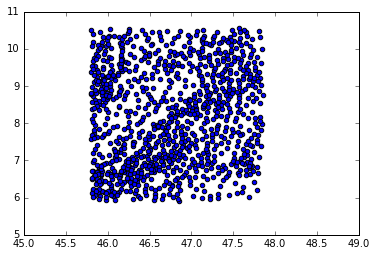

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.xlim(45, 49)
plt.ylim(5, 11)
plt.scatter(centroids[:, 1], centroids[:, 0])
plt.show()

In [54]:
np_array = non_urban[["longitude","latitude"]].as_matrix()
np_array.shape

(1199362, 2)

We compute the predicitons of the cluster for each tweet based on the computed model. Predict only 100'000 tweets at the same for memory purpose.

In [55]:
step = 100000
predictions = [[]]

for i in range(int(np_array.shape[0]/step)):
    if i == 0:
        predictions = kmeans.predict(np_array[i*step:(i+1)*step])
    else :
        predictions = np.concatenate([predictions, kmeans.predict(np_array[i*step:(i+1)*step])])

In [56]:
i = i+1
predictions = np.concatenate([predictions, kmeans.predict(np_array[i*step:(i+1)*step])])

In [57]:
predictions.shape

(1199362,)

In [58]:
predictions

array([644, 102, 102, ..., 838, 497, 105], dtype=int32)

In [59]:
np.savetxt("data/cluster_assignements.csv", predictions.astype(int), fmt='%d')

In [60]:
non_urban["cluster"] = predictions
non_urban.head()

,date,longitude,latitude,used,cluster
0,,,,,
9564875001,2010-02-24 06:26:53,7.44237,46.8958,True,644
9575552318,2010-02-24 13:28:52,8.06674,46.3913,True,102
9575623646,2010-02-24 13:30:51,8.06763,46.3910,True,102
9587557928,2010-02-24 18:45:38,8.77847,47.2034,True,919
9621355274,2010-02-25 11:16:50,7.53729,46.8894,True,69


## Data exporting

We now save all the data of the intersting tweets. Their id, date, longitude, latitude, and assigned cluster. We also save the clusters information.

This will be used by other notebook to analyze the cluster.

In [61]:
non_urban.to_csv("data/cleaned_non_urban_with_clusters.tsv", sep="\t")

In [64]:
clusters_centers = kmeans.cluster_centers_

In [66]:
clusters_centers

array([[  7.62471007,  45.87832853],
       [  9.89960578,  46.49609189],
       [  6.57002659,  45.83524913],
       ..., 
       [  7.16570062,  47.62351228],
       [  6.77596923,  46.52317153],
       [  7.06355514,  47.5930047 ]])

In [67]:
pd.DataFrame(clusters_centers).to_csv("data/clusters_centers.tsv", sep="\t")